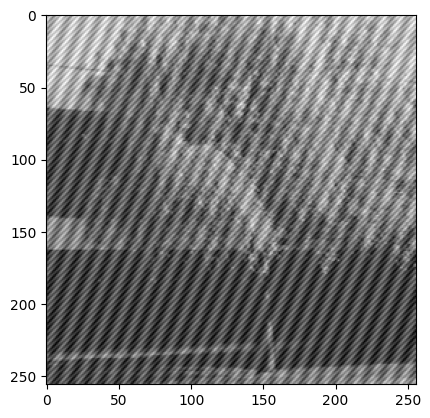

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import rotate
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio as PSNR
from scipy import signal


def gaussian_filter(n_rows, n_cols, stdv):
    """
    Returns a 2d Gaussian image filter.
    """
    g_r = signal.windows.gaussian(n_rows, stdv)
    g_c = signal.windows.gaussian(n_cols, stdv)

    G = np.outer(g_r, g_c)

    return G/np.sum(G)

plt.gray()
lena= rgb2gray(imread('lena.tiff'))
frequnoisy = imread('frequnoisy.tif').astype(np.float64)/255
plt.imshow(frequnoisy)

# 2. Fourier Analysis

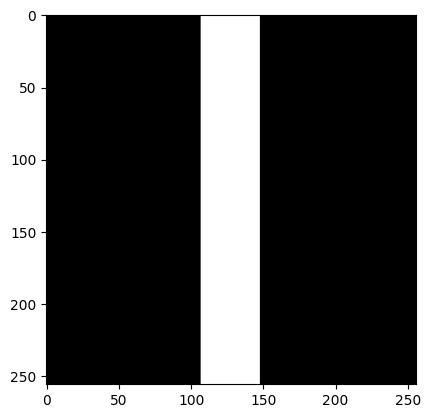

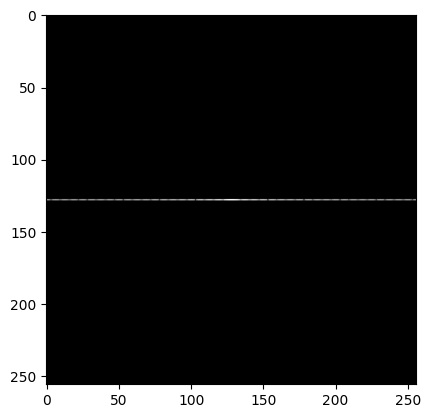

In [12]:
toy = np.zeros((256,256))
toy[:,107:148] = 1
plt.imshow(toy)
plt.show()

f_toy = np.fft.fftshift(np.fft.fft2(toy))
plt.imshow(np.log(np.abs(f_toy) + 1))
plt.show()  

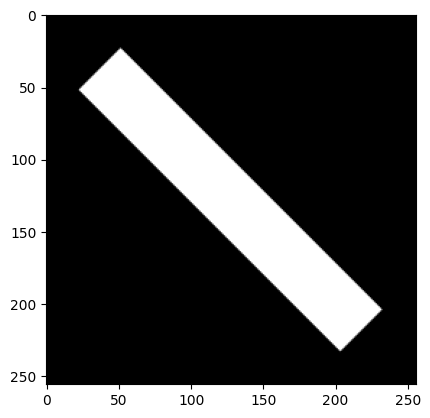

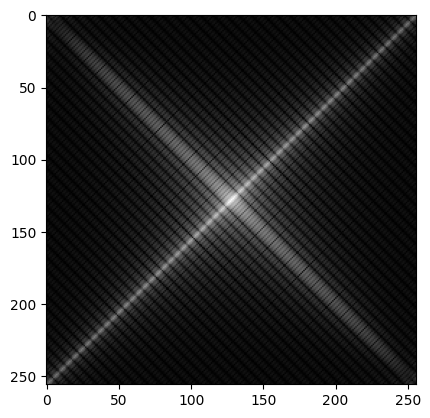

In [13]:
toy_rotated = rotate(toy, 45)
plt.imshow(toy_rotated)
plt.show()
f_rotated = np.fft.fftshift(np.fft.fft2(toy_rotated))
plt.imshow(np.log(np.abs(f_rotated) + 1))
plt.show()